# Resampling

In [1]:
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load HDF5 file with data
f = h5py.File('data.hdf5')
spectra = f['spectra']

## Wavelength range

In [3]:
# list of starting wavelens
wavelen_starts = list(map(
    lambda x: x['wave'][0], spectra.values()
))
# list of ending wavelens
wavelen_ends = list(map(
    lambda x: x['wave'][-1], spectra.values()
))

(array([  1.10300000e+03,   1.21070000e+04,   5.00000000e+00,
          1.50000000e+01,   0.00000000e+00,   3.60000000e+01,
          7.50000000e+01,   1.00000000e+00,   0.00000000e+00,
          3.00000000e+00]),
 array([ 6222.4026459 ,  6252.0050907 ,  6281.6075355 ,  6311.2099803 ,
         6340.8124251 ,  6370.41486989,  6400.01731469,  6429.61975949,
         6459.22220429,  6488.82464909,  6518.42709388]))

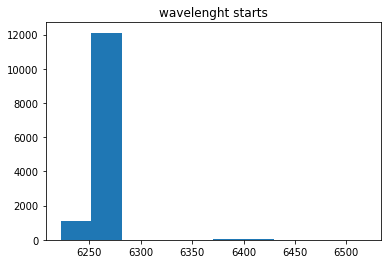

In [4]:
# show histogram
starts_n, starts_bins, _ = plt.hist(wavelen_starts)
plt.title('wavelenght starts')
starts_n, starts_bins

In [5]:
# derived from data above
start = 6282

(array([  4.37900000e+03,   8.83900000e+03,   0.00000000e+00,
          1.20000000e+01,   6.00000000e+01,   3.40000000e+01,
          1.70000000e+01,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 6733.49077681,  6763.18532498,  6792.87987315,  6822.57442133,
         6852.2689695 ,  6881.96351767,  6911.65806584,  6941.35261401,
         6971.04716218,  7000.74171036,  7030.43625853]))

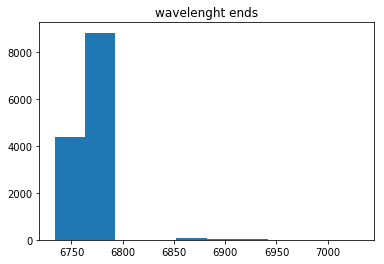

In [6]:
plt.title('wavelenght ends')
ends_n, ends_bins, _ = plt.hist(wavelen_ends)
ends_n, ends_bins

In [7]:
end = 6733

(array([ 9242.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4103.]),
 array([ 1997.,  2002.,  2007.,  2012.,  2017.,  2022.,  2027.,  2032.,
         2037.,  2042.,  2047.]),
 <a list of 10 Patch objects>)

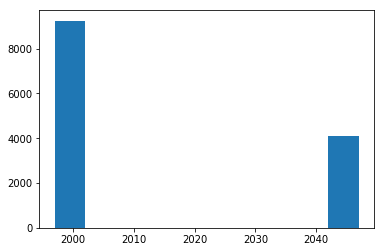

In [8]:
wavelen_lens = np.array([x['wave'].shape[0] for x in spectra.values()])
plt.hist(wavelen_lens)

In [9]:
for waves, count in zip(*np.unique(wavelen_lens, return_counts=True)):
    print('{} waves: {} samples'.format(waves, count))

1997 waves: 9242 samples
2047 waves: 4103 samples


## Sample-rate Conversion

Sample-rate conversion it the process of changing the
sampling rate of discrete signal to get new representation
of the underlying continuous signal. The sampling rate
can be either increased (upsampling) or decreased
(decimation).

In [10]:
_, test_spectrum = random.choice(list(spectra.items()))
_, bar = random.choice(list(spectra.items()))

In [11]:
# sampled at different wavelens
test_spectrum['wave'], bar['wave']

(<HDF5 dataset "wave": shape (1997,), type ">f8">,
 <HDF5 dataset "wave": shape (1997,), type ">f8">)

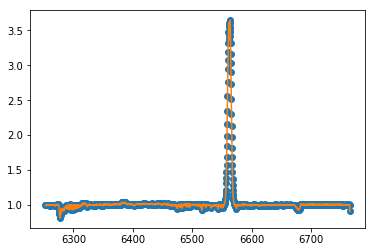

In [12]:
def plot_spectrum_with_points(spectrum):
    x = spectrum['wave']
    y = spectrum['flux']
    plt.plot(x, y, 'o', x, y)

plot_spectrum_with_points(test_spectrum)

If resampled, upsampled and downsampled data are
plotted it can be seen then surely upsampling is the best.
Downsampling may lost some peaks. Therefore, upsampling
is choosen but smaller sample-rate can be choosen if
computation difficulties will be observed.

In [13]:
def resample_flux(new_wavelens, wavelens, flux):
    '''Resample spectrum defined by wavelens and flux
    to new_wavelens.'''
    return np.interp(new_wavelens, wavelens, flux)

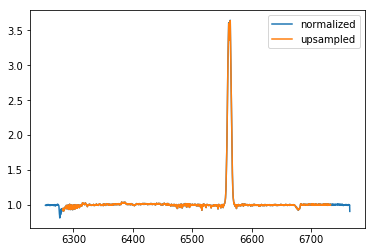

In [14]:
plt.plot(test_spectrum['wave'], test_spectrum['flux'], label='normalized')

# plot upsampled spectrum
upsampled_wavelens = np.linspace(start, end, 4000)
plt.plot(
    upsampled_wavelens,
    resample_flux(upsampled_wavelens, test_spectrum['wave'], test_spectrum['flux']),
    label='upsampled'
)
_ = plt.legend()

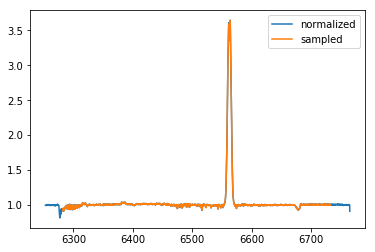

In [15]:
# plot normalized spectrum
plt.plot(test_spectrum['wave'], test_spectrum['flux'], label='normalized')

# define new wavelens whe number of wavelens is the same
# as in original spectrum
n_wavelens = test_spectrum['wave'].shape[0]
sampled_wavelens = np.linspace(start, end, n_wavelens)
# plot sampled spectrum
plt.plot(
    sampled_wavelens,
    resample_flux(sampled_wavelens, test_spectrum['wave'], test_spectrum['flux']),
    label='sampled'
)
_ = plt.legend()

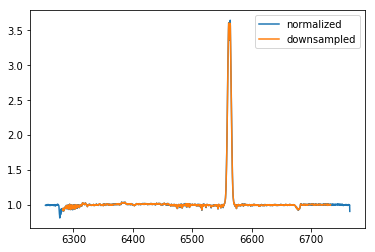

In [16]:
plt.plot(test_spectrum['wave'], test_spectrum['flux'], label='normalized')

# plot downsampled spectrum
downsampled_wavelens = np.linspace(start, end, 1000)
plt.plot(
    downsampled_wavelens,
    resample_flux(downsampled_wavelens, test_spectrum['wave'], test_spectrum['flux']),
    label='downsampled'
)
_ = plt.legend()

In [17]:
def are_wavelens_in_range(wavelen, start, end):
    return wavelen[0] < start and wavelen[-1] > end
    
are_wavelens_in_range(
    test_spectrum['wave'],
    start,
    end
)

True

In [18]:
idents = np.array([
    ident
    for ident, data in spectra.items()
    if are_wavelens_in_range(data['wave'], start, end)
        and ident != 'rd270026' # this is outlier
])
idents

array(['a201305230017', 'a201306060015', 'a201306060016', ..., 'we180033',
       'we200014', 'we200016'], 
      dtype='<U14')

In [19]:
if 'resampled/idents' in f:
    del f['resampled/idents']

dset = f.create_dataset(
    'resampled/idents',
    idents.shape,
    dtype=h5py.special_dtype(vlen=str)
)

dset[...] = idents

In [20]:
if 'resampled/wave' in f:
    del f['resampled/wave']

dset = f.create_dataset(
    'resampled/wave',
    upsampled_wavelens.shape,
    dtype=upsampled_wavelens.dtype
)

dset[...] = upsampled_wavelens

In [21]:
if 'resampled/fluxes' in f:
    del f['resampled/fluxes']

flux_dtype = test_spectrum['flux'].dtype

fluxes = f.create_dataset(
    'resampled/fluxes',
    (idents.shape[0], 4000),
    dtype=flux_dtype
)

for idx, ident in enumerate(idents):
    spectrum = spectra[ident]
    fluxes[idx, :] = resample_flux(upsampled_wavelens, spectrum['wave'], spectrum['flux']),

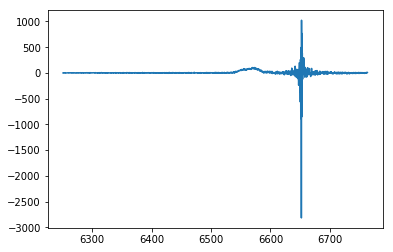

In [22]:
# corrupted spectrum
corrupted = spectra['rd270026']
plt.plot(corrupted['wave'], corrupted['flux'])

In [23]:
f.close()